# End-to-End Multiclass Image Classification Example
1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Prepare the data](#Prepare-the-data)
3. [Training the model](#Training-the-model)
  1. [Training parameters](#Training-parameters)
  2. [Start the training](#Start-the-training)
4. [Compile](#Compile)
5. [Inference](#Inference)

## Introduction

Welcome to our end-to-end example of distributed image classification algorithm. In this demo, we will use the Amazon sagemaker image classification algorithm to train on the [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [2]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "ic-fulltraining"

In [3]:
from sagemaker import image_uris

training_image = image_uris.retrieve(
    region=sess.boto_region_name, framework="image-classification", version="latest"
)
print(training_image)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


### Data preparation
Download the data and transfer to S3 for use in training. In this demo, we are using [Caltech-256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/) dataset, which contains 30608 images of 256 objects. For the training and validation data, we follow the splitting scheme in this MXNet [example](https://github.com/apache/incubator-mxnet/blob/master/example/image-classification/data/caltech256.sh). In particular, it randomly selects 60 images per class for training, and uses the remaining data for validation. The algorithm takes `RecordIO` file as input. The user can also provide the image files as input, which will be converted into `RecordIO` format using MXNet's [im2rec](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec) tool. It takes around 50 seconds to converted the entire Caltech-256 dataset (~1.2GB) on a p2.xlarge instance. However, for this demo, we will use record io format. 

In [4]:
import os
import urllib.request
import boto3


def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


def upload_to_s3(channel, file):
    s3 = boto3.resource("s3")
    data = open(file, "rb")
    key = channel + "/" + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# caltech-256
download("http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec")
download("http://data.mxnet.io/data/caltech-256/caltech-256-60-val.rec")

In [5]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = "s3://{}/{}/train/".format(bucket, prefix)
s3validation = "s3://{}/{}/validation/".format(bucket, prefix)

# upload the lst files to train and validation channels
!aws s3 cp caltech-256-60-train.rec $s3train --quiet
!aws s3 cp caltech-256-60-val.rec $s3validation --quiet



Once we have the data available in the correct format for training, the next step is to actually train the model using the data. After setting training parameters, we kick off training, and poll for status until training is completed.


## Training the model

Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training 
* **Output path**: This the s3 folder in which the training output is stored


In [6]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)
ic = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class.
* **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **top_k**: Report the top-k accuracy during training.
* **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode


In [7]:
ic.set_hyperparameters(
    num_layers=18,
    image_shape="3,224,224",
    num_classes=257,
    num_training_samples=15420,
    mini_batch_size=128,
    epochs=5,
    learning_rate=0.01,
    top_k=2,
    precision_dtype="float32",
)

## Input data specification
Set the data type and channels used for training

In [8]:
train_data = sagemaker.inputs.TrainingInput(
    s3train,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3validation,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)

data_channels = {"train": train_data, "validation": validation_data}

## Start the training
Start training by calling the fit method in the estimator

In [9]:
ic.fit(inputs=data_channels, logs=True)

2022-04-12 15:48:52 Starting - Starting the training job...
2022-04-12 15:49:19 Starting - Preparing the instances for trainingProfilerReport-1649778532: InProgress
.........
2022-04-12 15:50:46 Downloading - Downloading input data......
2022-04-12 15:51:42 Training - Downloading the training image.........
2022-04-12 15:53:18 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[04/12/2022 15:53:25 INFO 140142291134272] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[04/12/2022 15:53:25 INFO 140142291134272] Merging with provided configuration from 

# Local Deploy

In [86]:
ic.model_data

's3://sagemaker-us-east-1-432088571089/ic-fulltraining/output/image-classification-2022-04-12-15-48-52-687/output/model.tar.gz'

In [87]:
!aws s3 cp {ic.model_data} ./model.tar.gz

download: s3://sagemaker-us-east-1-432088571089/ic-fulltraining/output/image-classification-2022-04-12-15-48-52-687/output/model.tar.gz to ./model.tar.gz


In [88]:
!mkdir -p ic_model
!cp -f ./model.tar.gz ./ic_model



In [89]:
!tar -zxvf ./ic_model/model.tar.gz -C ./ic_model

image-classification-symbol.json
image-classification-0005.params
model-shapes.json


In [90]:
!pip install mxnet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [91]:
#!pip install opencv-python
!pip install opencv-python-headless

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [95]:
import mxnet as mx
import matplotlib.pyplot as plt
import cv2
import numpy as np
from mxnet.io import DataBatch

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (64, 64))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url, labels):
    img = get_image(url, show=True)
    # compute the predict probabilities
    lenet_model.forward(DataBatch([mx.nd.array(img)]))
    prob = lenet_model.get_outputs()[0].asnumpy()

    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]

    for i in a[0:5]:
       print('probability=%f, class=%s' %(prob[i], labels[i]))

In [96]:
lenet_model = mx.mod.Module.load('ic_model/image-classification',5)
image_l = 224
image_w = 224
lenet_model.bind(for_training=False, data_shapes=[('data',(1,3,image_l,image_w))],label_shapes=lenet_model._label_shapes)


### Download test image

--2022-04-13 03:35:23--  http://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/256_ObjectCategories/008.bathtub/008_0007.jpg
Resolving sagemaker-sample-files.s3.amazonaws.com (sagemaker-sample-files.s3.amazonaws.com)... 52.216.138.243
Connecting to sagemaker-sample-files.s3.amazonaws.com (sagemaker-sample-files.s3.amazonaws.com)|52.216.138.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23750 (23K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  23.19K  --.-KB/s    in 0.001s  

2022-04-13 03:35:23 (16.8 MB/s) - ‘test.jpg’ saved [23750/23750]



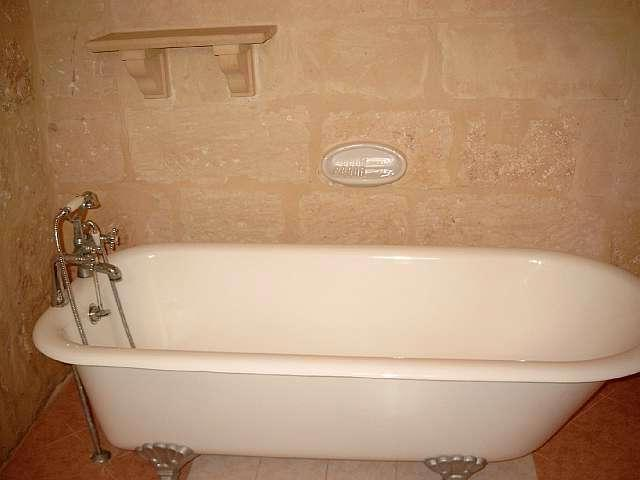

In [97]:
!wget -O test.jpg http://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/256_ObjectCategories/008.bathtub/008_0007.jpg
file_name = "test.jpg"
# test image
from IPython.display import Image

Image(file_name)

### Evaluation

Evaluate the image through the network for inteference. The network outputs class probabilities and typically, one selects the class with the maximum probability as the final class output.

**Note:** The output class detected by the network may not be accurate in this example. To limit the time taken and cost of training, we have trained the model only for 5 epochs. If the network is trained for more epochs (say 20), then the output class will be more accurate.

In [98]:
object_categories = [
    "ak47",
    "american-flag",
    "backpack",
    "baseball-bat",
    "baseball-glove",
    "basketball-hoop",
    "bat",
    "bathtub",
    "bear",
    "beer-mug",
    "billiards",
    "binoculars",
    "birdbath",
    "blimp",
    "bonsai-101",
    "boom-box",
    "bowling-ball",
    "bowling-pin",
    "boxing-glove",
    "brain-101",
    "breadmaker",
    "buddha-101",
    "bulldozer",
    "butterfly",
    "cactus",
    "cake",
    "calculator",
    "camel",
    "cannon",
    "canoe",
    "car-tire",
    "cartman",
    "cd",
    "centipede",
    "cereal-box",
    "chandelier-101",
    "chess-board",
    "chimp",
    "chopsticks",
    "cockroach",
    "coffee-mug",
    "coffin",
    "coin",
    "comet",
    "computer-keyboard",
    "computer-monitor",
    "computer-mouse",
    "conch",
    "cormorant",
    "covered-wagon",
    "cowboy-hat",
    "crab-101",
    "desk-globe",
    "diamond-ring",
    "dice",
    "dog",
    "dolphin-101",
    "doorknob",
    "drinking-straw",
    "duck",
    "dumb-bell",
    "eiffel-tower",
    "electric-guitar-101",
    "elephant-101",
    "elk",
    "ewer-101",
    "eyeglasses",
    "fern",
    "fighter-jet",
    "fire-extinguisher",
    "fire-hydrant",
    "fire-truck",
    "fireworks",
    "flashlight",
    "floppy-disk",
    "football-helmet",
    "french-horn",
    "fried-egg",
    "frisbee",
    "frog",
    "frying-pan",
    "galaxy",
    "gas-pump",
    "giraffe",
    "goat",
    "golden-gate-bridge",
    "goldfish",
    "golf-ball",
    "goose",
    "gorilla",
    "grand-piano-101",
    "grapes",
    "grasshopper",
    "guitar-pick",
    "hamburger",
    "hammock",
    "harmonica",
    "harp",
    "harpsichord",
    "hawksbill-101",
    "head-phones",
    "helicopter-101",
    "hibiscus",
    "homer-simpson",
    "horse",
    "horseshoe-crab",
    "hot-air-balloon",
    "hot-dog",
    "hot-tub",
    "hourglass",
    "house-fly",
    "human-skeleton",
    "hummingbird",
    "ibis-101",
    "ice-cream-cone",
    "iguana",
    "ipod",
    "iris",
    "jesus-christ",
    "joy-stick",
    "kangaroo-101",
    "kayak",
    "ketch-101",
    "killer-whale",
    "knife",
    "ladder",
    "laptop-101",
    "lathe",
    "leopards-101",
    "license-plate",
    "lightbulb",
    "light-house",
    "lightning",
    "llama-101",
    "mailbox",
    "mandolin",
    "mars",
    "mattress",
    "megaphone",
    "menorah-101",
    "microscope",
    "microwave",
    "minaret",
    "minotaur",
    "motorbikes-101",
    "mountain-bike",
    "mushroom",
    "mussels",
    "necktie",
    "octopus",
    "ostrich",
    "owl",
    "palm-pilot",
    "palm-tree",
    "paperclip",
    "paper-shredder",
    "pci-card",
    "penguin",
    "people",
    "pez-dispenser",
    "photocopier",
    "picnic-table",
    "playing-card",
    "porcupine",
    "pram",
    "praying-mantis",
    "pyramid",
    "raccoon",
    "radio-telescope",
    "rainbow",
    "refrigerator",
    "revolver-101",
    "rifle",
    "rotary-phone",
    "roulette-wheel",
    "saddle",
    "saturn",
    "school-bus",
    "scorpion-101",
    "screwdriver",
    "segway",
    "self-propelled-lawn-mower",
    "sextant",
    "sheet-music",
    "skateboard",
    "skunk",
    "skyscraper",
    "smokestack",
    "snail",
    "snake",
    "sneaker",
    "snowmobile",
    "soccer-ball",
    "socks",
    "soda-can",
    "spaghetti",
    "speed-boat",
    "spider",
    "spoon",
    "stained-glass",
    "starfish-101",
    "steering-wheel",
    "stirrups",
    "sunflower-101",
    "superman",
    "sushi",
    "swan",
    "swiss-army-knife",
    "sword",
    "syringe",
    "tambourine",
    "teapot",
    "teddy-bear",
    "teepee",
    "telephone-box",
    "tennis-ball",
    "tennis-court",
    "tennis-racket",
    "theodolite",
    "toaster",
    "tomato",
    "tombstone",
    "top-hat",
    "touring-bike",
    "tower-pisa",
    "traffic-light",
    "treadmill",
    "triceratops",
    "tricycle",
    "trilobite-101",
    "tripod",
    "t-shirt",
    "tuning-fork",
    "tweezer",
    "umbrella-101",
    "unicorn",
    "vcr",
    "video-projector",
    "washing-machine",
    "watch-101",
    "waterfall",
    "watermelon",
    "welding-mask",
    "wheelbarrow",
    "windmill",
    "wine-bottle",
    "xylophone",
    "yarmulke",
    "yo-yo",
    "zebra",
    "airplanes-101",
    "car-side-101",
    "faces-easy-101",
    "greyhound",
    "tennis-shoes",
    "toad",
    "clutter",
]


probability=0.011928, class=conch
probability=0.011278, class=spoon
probability=0.011223, class=hot-dog
probability=0.010507, class=bathtub
probability=0.010196, class=ostrich


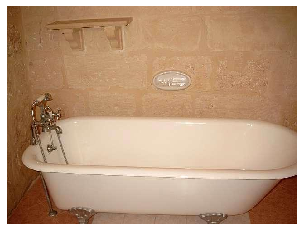

In [76]:
predict('test.jpg', object_categories )